<a href="https://colab.research.google.com/github/tonyk0121/CLIP_Navigation_ToyProject/blob/main/CLIP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP을 활용한 Navigation
간단한 방 시뮬레이션을 만들고, 4방위의 사진에 CLIP모델을 입력으로 하여 `target`에 도달할 때까지 DFS를 수행한다.

**아래 블럭에서 업로드할 파일** : `room_cfg.yaml`, `room_images.zip`

- `room_cfg.yaml` : 방 그래프 자료구조로 형성하기 위한 cfg 파일. (room_id, room_images, neighbors)

- `room_images.zip` : 각 방마다의 4방위 사진 모음

In [ ]:
from google.colab import files
# upload 'room_cfg.yaml', 'room_images.zip'
uploaded = files.upload()

Saving room_cfg.yaml to room_cfg.yaml
Saving room_images.zip to room_images.zip


In [ ]:
!unzip -q "/content/room_images.zip" -d "/content/room_images"

In [ ]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
# CLIP 관련 라이브러리
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# 기타 관련 라이브러리
!pip install PyYAML Pillow

/bin/bash: line 1: conda: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gwhqzkmq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-gwhqzkmq
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=76df411741a179d3c40bb7b7e4fd5080cd045465606f4609a8ef06a5c47e9c88
  Stored in directory: /tmp/pip-ephem-wheel-cache-ue49jvbr/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
# @title
import yaml
import os
import torch
import clip
from PIL import Image
from collections import deque
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Set
import argparse
import cv2

import matplotlib.pyplot as plt

In [ ]:
# @title
@dataclass
class Room:
    """방 정보를 저장하는 데이터 클래스"""
    room_id: str
    images: Dict[str, str]  # 방향별 이미지 파일명
    neighbors: List[str]    # 인접한 방들의 ID


class RoomGraph:
    """집의 그래프 구조를 관리하는 클래스"""

    def __init__(self, config_path: str):
        self.config_path = config_path
        self.rooms: Dict[str, Room] = {}
        self.load_config()

    def load_config(self):
        """YAML 설정 파일을 로드하여 그래프 구조를 생성"""
        with open(self.config_path, 'r', encoding='utf-8') as file:
            data = yaml.safe_load(file)

        for room_data in data['rooms']:
            room = Room(
                room_id=room_data['room_id'],
                images=room_data['images'],
                neighbors=room_data['neighbors']
            )
            self.rooms[room.room_id] = room

    def get_neighbors(self, room_id: str) -> List[str]:
        """특정 방의 인접한 방들을 반환"""
        if room_id not in self.rooms:
            return []
        return self.rooms[room_id].neighbors

    def get_room(self, room_id: str) -> Optional[Room]:
        """특정 방의 정보를 반환"""
        return self.rooms.get(room_id)

    def get_all_rooms(self) -> List[str]:
        """모든 방의 ID를 반환"""
        return list(self.rooms.keys())

    def get_room_images(self, room_id: str, images_dir: Optional[str] = None):
        """
        주어진 room_id의 모든 이미지를 좌우로 이어서(concat) OpenCV로 보여줌.
        images_dir를 지정하지 않으면 현재 디렉토리를 사용.
        """
        import cv2
        room = self.get_room(room_id)
        if not room or not room.images:
            print("해당 방을 찾을 수 없거나 이미지 정보가 없습니다.")
            return

        base_dir = images_dir if images_dir is not None else "."
        img_paths = [os.path.join(base_dir, fname) for fname in room.images.values()]
        imgs = []
        for p in img_paths:
            if not os.path.exists(p):
                print(f"이미지 파일을 찾을 수 없습니다: {p}")
                continue
            img = cv2.imread(p)
            if img is None:
                print(f"이미지 로드 실패: {p}")
                continue
            imgs.append(img)
        if not imgs:
            print("이미지를 로드할 수 없습니다.")
            return

        # 이미지 크기 다르면 resize (가로: min width, 세로: min height)
        min_height = min(img.shape[0] for img in imgs)
        min_width = min(img.shape[1] for img in imgs)
        resized_imgs = [cv2.resize(img, (min_width, min_height)) for img in imgs]

        concat_img = cv2.hconcat(resized_imgs)
        cv2.imshow(f"Room {room_id} images", concat_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def dfs_search(self, start_room: str, visited: Set[str] = None) -> List[str]:
        """DFS 탐색을 수행하여 방문 순서를 반환"""
        if visited is None:
            visited = set()

        if start_room in visited:
            return []

        visited.add(start_room)
        path = [start_room]

        for neighbor in self.get_neighbors(start_room):
            if neighbor not in visited:
                path.extend(self.dfs_search(neighbor, visited))

        return path


In [ ]:
# @title

class CLIPNavigator:
    """CLIP 모델을 사용하여 방을 인식하는 클래스"""

    def __init__(self, images_dir: str, threshold: float = 0.25):
        self.images_dir = images_dir
        self.threshold = threshold
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        print(f"CLIP 모델이 {self.device}에서 로드되었습니다.")

    def load_room_images(self, room: Room) -> List[Image.Image]:
        """특정 방의 모든 방향 이미지를 로드"""
        images = []
        for direction, image_file in room.images.items():
            image_path = os.path.join(self.images_dir, image_file)
            if os.path.exists(image_path):
                try:
                    image = Image.open(image_path)
                    images.append(image)
                except Exception as e:
                    print(f"이미지 로드 실패: {image_path}, 오류: {e}")
            else:
                print(f"이미지 파일을 찾을 수 없습니다: {image_path}")
        return images

    def calculate_similarity(self, images: List[Image.Image], text_query: str) -> float:
        """이미지들과 텍스트 쿼리 간의 최대 유사도를 계산"""
        if not images:
            return 0.0

        # 텍스트 토큰화
        text_tokens = clip.tokenize([text_query]).to(self.device)

        # 이미지 전처리 및 텐서 변환
        image_tensors = []
        for image in images:
            processed_image = self.preprocess(image).unsqueeze(0).to(self.device)
            image_tensors.append(processed_image)

        # 배치로 처리
        image_batch = torch.cat(image_tensors, dim=0)

        with torch.no_grad():
            # 이미지와 텍스트 특징 추출
            image_features = self.model.encode_image(image_batch)
            text_features = self.model.encode_text(text_tokens)

            # 정규화
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # 유사도 계산 (코사인 유사도)
            similarities = torch.cosine_similarity(image_features, text_features, dim=-1)

            # 최대 유사도 반환
            max_similarity = similarities.max().item()

        return max_similarity

    def is_target_room(self, room: Room, target_query: str) -> Tuple[bool, float]:
        """특정 방이 목표 방인지 판단"""
        images = self.load_room_images(room)
        similarity = self.calculate_similarity(images, target_query)

        is_target = similarity >= self.threshold
        return is_target, similarity


class NavigationSimulator:
    """전체 내비게이션 시뮬레이션을 관리하는 메인 클래스"""

    def __init__(self, config_path: str, images_dir: str, threshold: float = 0.25):
        self.room_graph = RoomGraph(config_path)
        self.clip_navigator = CLIPNavigator(images_dir, threshold)
        self.visited_rooms: Set[str] = set()
        self.search_path: List[str] = []

    def navigate_to_target(self, target_query: str, start_room: str = "enterway") -> Dict:
        """목표 방을 찾기 위한 내비게이션 실행"""
        print(f"목표: '{target_query}' 찾기 시작")
        print(f"시작 위치: {start_room}")
        print(f"임계값: {self.clip_navigator.threshold}")
        print("-" * 50)

        # 초기화
        self.visited_rooms.clear()
        self.search_path.clear()

        # DFS 탐색 실행
        result = self._dfs_search_target(start_room, target_query)

        return result

    def _dfs_search_target(self, current_room: str, target_query: str) -> Dict:
        """DFS를 사용하여 목표 방을 탐색"""
        if current_room in self.visited_rooms:
            return {"found": False, "path": self.search_path.copy(), "message": "이미 방문한 방"}

        # 현재 방 방문 처리
        self.visited_rooms.add(current_room)
        self.search_path.append(current_room)

        print(f"현재 위치: {current_room}")

        # 현재 방이 목표인지 확인
        room = self.room_graph.get_room(current_room)
        if room:
            is_target, similarity = self.clip_navigator.is_target_room(room, target_query)
            print(f"  유사도: {similarity:.3f}")

            if is_target:
                print(f"🎉 목표 방 '{target_query}'을 찾았습니다! ({current_room})")

                # 목표 방의 이미지들을 plot
                self.plot_room_images(current_room)
                return {
                    "found": True,
                    "target_room": current_room,
                    "path": self.search_path.copy(),
                    "similarity": similarity,
                    "message": f"목표 방을 찾았습니다: {current_room}"
                }

        # 인접한 방들을 탐색
        neighbors = self.room_graph.get_neighbors(current_room)
        print(f"  인접한 방들: {neighbors}")

        for neighbor in neighbors:
            if neighbor not in self.visited_rooms:
                result = self._dfs_search_target(neighbor, target_query)
                if result["found"]:
                    return result

        # 백트래킹
        self.search_path.pop()
        return {"found": False, "path": self.search_path.copy(), "message": "목표를 찾지 못함"}

    def plot_room_images(self, room_id: str):
        """특정 방의 이미지들을 matplotlib으로 plot"""
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        room = self.room_graph.get_room(room_id)
        if not room or not room.images:
            print("해당 방을 찾을 수 없거나 이미지 정보가 없습니다.")
            return

        # 이미지 파일 경로들 생성
        image_paths = []
        directions = []
        direction_map = {
            'north': 'North',
            'east': 'East',
            'west': 'West',
            'south': 'South'
        }

        for direction, image_file in room.images.items():
            image_path = os.path.join(self.clip_navigator.images_dir, image_file)
            if os.path.exists(image_path):
                image_paths.append(image_path)
                directions.append(direction_map.get(direction, direction.upper()))

        if not image_paths:
            print("표시할 이미지가 없습니다.")
            return

        # subplot 설정
        fig, axes = plt.subplots(1, len(image_paths), figsize=(4*len(image_paths), 4))
        if len(image_paths) == 1:
            axes = [axes]

        # 각 방향별 이미지 표시
        for i, (path, direction) in enumerate(zip(image_paths, directions)):
            img = mpimg.imread(path)
            axes[i].imshow(img)
            axes[i].set_title(f"{direction} View")
            axes[i].axis('off')

        plt.suptitle(f"Target Room '{room_id}' Images", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def print_navigation_result(self, result: Dict):
        """내비게이션 결과를 출력"""
        print("\n" + "=" * 50)
        print("내비게이션 결과")
        print("=" * 50)

        if result["found"]:
            print(f"✅ 성공: {result['message']}")
            print(f"목표 방: {result['target_room']}")
            print(f"유사도: {result['similarity']:.3f}")
        else:
            print(f"❌ 실패: {result['message']}")

        print(f"탐색 경로: {' → '.join(result['path'])}")
        print(f"총 방문한 방 수: {len(result['path'])}")
        print(f"전체 방 수: {len(self.room_graph.get_all_rooms())}")

    def get_room_info(self, room_id: str) -> Optional[Dict]:
        """특정 방의 정보를 반환"""
        room = self.room_graph.get_room(room_id)
        if room:
            return {
                "room_id": room.room_id,
                "images": room.images,
                "neighbors": room.neighbors
            }
        return None


 # Task : 방 찾기
 성공 목록 : "washroom", "bathroom", "livingroom", "playroom", "bedroom", "living room", "storage room : 현관을 찾음(아마 신발 때문)", "shower room : shower은 찾지 못함"

 실패 목록 : "balcony : 한국식 베란다라 안되는듯"

 # Task : 물건 찾기
 (threshold를 0.25로 낮추면 보인다.)
 이미지에서 크게 찍힌 물건들만 보임
 성공 목록 : "sink", "toilet", "table", "bed"

 실패 목록 : "microwave"

CLIP 모델이 cuda에서 로드되었습니다.
목표: 'bedroom' 찾기 시작
시작 위치: enterway
임계값: 0.28
--------------------------------------------------
현재 위치: enterway
  유사도: 0.251
  인접한 방들: ['hallway1']
현재 위치: hallway1
  유사도: 0.261
  인접한 방들: ['enterway', 'bathroom1', 'hallway2', 'bedroom2']
현재 위치: bathroom1
  유사도: 0.241
  인접한 방들: ['hallway1']
현재 위치: hallway2
  유사도: 0.262
  인접한 방들: ['hallway1', 'livingroom', 'kitchen', 'bedroom1']
현재 위치: livingroom
  유사도: 0.269
  인접한 방들: ['hallway2', 'balcony']
현재 위치: balcony
  유사도: 0.223
  인접한 방들: ['livingroom']
현재 위치: kitchen
  유사도: 0.251
  인접한 방들: ['hallway2', 'storage_room']
현재 위치: storage_room
  유사도: 0.245
  인접한 방들: ['kitchen']
현재 위치: bedroom1
  유사도: 0.282
🎉 목표 방 'bedroom'을 찾았습니다! (bedroom1)


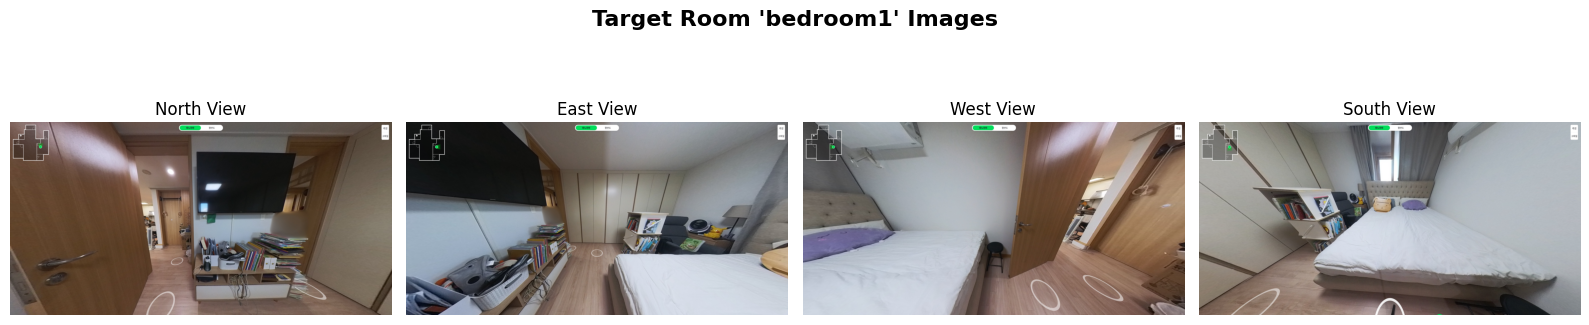


내비게이션 결과
✅ 성공: 목표 방을 찾았습니다: bedroom1
목표 방: bedroom1
유사도: 0.282
탐색 경로: enterway → hallway1 → hallway2 → bedroom1
총 방문한 방 수: 4
전체 방 수: 12


In [ ]:
target= "bedroom"

try:
    # 내비게이션 시뮬레이터 초기화
    simulator = NavigationSimulator(config_path="room_cfg.yaml", images_dir="room_images", threshold=0.28) # 방을 찾을 경우 0.28 / 물건을 찾을 경우 0.25

    # 내비게이션 실행
    result = simulator.navigate_to_target(target_query=target, start_room="enterway") # default : 현관에서 시작

    # 결과 출력
    simulator.print_navigation_result(result)

except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")